# Experiments with Shape Distributions

In this experiment, we consider barycentric merge trees (BMTs) for distributions on the manifold of planar polygons, from which we can get nice visualizations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mergeTrees import *

## Planar polygons and related functions

The next functions are used to generate, manipulate and visualize polygons in the plane.

In [2]:
def random_planar_polygon(n,mean = [0,0], cov = [[1,0],[0,1]]):
    
    polygon0 = np.random.multivariate_normal(mean,cov,n-1)
    zero_row = np.zeros(polygon0.shape[1])
    polygon = np.insert(polygon0, 0, zero_row, axis=0)
    
    length = np.sum([np.linalg.norm(polygon[i,:]) for i in range(polygon.shape[0])])
    
    polygon = 1/length*polygon
    
    return polygon

In [3]:
def polygon_edges(P):
    
    start_points = P
    end_points = np.roll(P, shift=-1, axis=0)
    vectors = end_points - start_points
    
    return vectors

In [4]:
def edges_to_points(P_edges):
    
    P = [[0,0]]
    
    for i in range(len(P_edges)-1):
        
        row = list(P_edges[i,:]+np.array(P[-1]))
        P.append(row)
        
    return np.array(P)

In [5]:
def draw_polygon(P):

    start_points = P
    end_points = np.roll(P, shift=-1, axis=0)
    vectors = end_points - start_points

    # Plot using quiver
    plt.figure(figsize=(6,6))
    plt.quiver(start_points[:,0], start_points[:,1], 
               vectors[:,0], vectors[:,1], 
               angles='xy', scale_units='xy', scale=1, 
               width=0.005, color='black')

    # Optional: plot the polygon vertices
    plt.plot(P[:,0], P[:,1], 'o', color='red')

    # Axis settings
    plt.axis('equal')
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.box(False)
    plt.show()

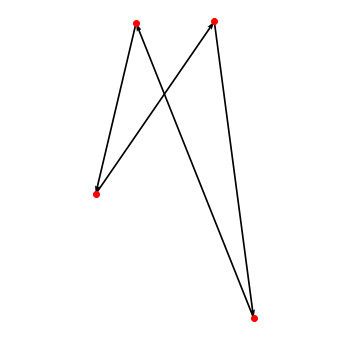

In [6]:
P = random_planar_polygon(4,cov = [[1,0],[0,1]])
draw_polygon(P)

In [7]:
def total_curvature(P):
    
    P_edges = polygon_edges(P)
    
    tot_curv = 0
    
    for i in range(len(P)-1):
        
        v1 = P_edges[i,:]
        v2 = P_edges[i+1,:]
        
        theta = np.arccos(v1@v2.T/(np.linalg.norm(v1)*np.linalg.norm(v2)))
        
        tot_curv += theta
        
    v1 = P_edges[-1,:]
    v2 = P_edges[0,:]
    theta = np.arccos(v1@v2.T/(np.linalg.norm(v1)*np.linalg.norm(v2)))
    tot_curv += theta
    
    return tot_curv

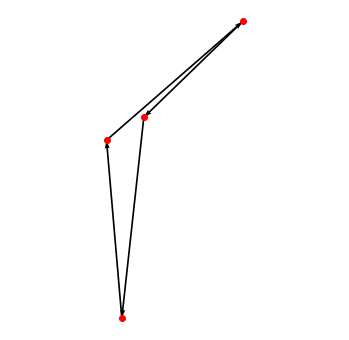

Total Curvature: 7.666270212160036


In [8]:
P = random_planar_polygon(4,cov = [[1,0],[0,1]])
draw_polygon(P)
print('Total Curvature:', total_curvature(P))

## Grassmannian Representation

A planar $n$-gon, considered up to translation, scale and rotation, can be identified with a point in the Grassmannian of 2-planes in $\mathbb{R}^n$. The following code is related to this representation.

In [9]:
def complex_square_root(a,b):
    
    mag = np.sqrt(a**2+b**2)

    if a==0:
        if b >= 0:
            angle = np.pi/2
        else:
            angle = 3*np.pi/2
    elif a > 0:
        angle = np.arctan(b/a)
    else:
        angle = np.arctan(b/a)+np.pi
    
    new_mag = np.sqrt(mag)
    new_angle = angle/2
    
    return [new_mag*np.cos(new_angle),new_mag*np.sin(new_angle)]

In [10]:
def polygon_to_grassmannian(P):
    
    grassmann_point = []
    
    P_edges = polygon_edges(P)
    
    for row in P_edges:
        new_row = complex_square_root(row[0],row[1])
        grassmann_point.append(new_row)
        
    return np.array(grassmann_point)

In [11]:
def complex_square(x,y):
    
    a = x**2-y**2
    b = 2*x*y
    
    return [a,b]

In [12]:
def grassmannian_to_polygon(G):
    
    P_edges = []
    
    for row in G:
        new_row = complex_square(row[0],row[1])
        P_edges.append(new_row)
        
    P_edges = np.array(P_edges)
    
    P = edges_to_points(P_edges)
    
    return P

In [13]:
def sample_stiefel(n, k):
    """
    Uniformly sample k points from the real Stiefel manifold St(2, n).

    Each sample is an n-by-2 matrix with orthonormal columns.

    Parameters:
        n (int): Number of rows.
        k (int): Number of samples.

    Returns:
        list of numpy.ndarray: List of k n-by-2 matrices with orthonormal columns.
    """
    samples = []
    for _ in range(k):
        A = np.random.randn(n, 2)
        Q, R = np.linalg.qr(A)
        # Ensure consistent orientation (optional but standard)
        Q *= np.sign(np.linalg.det(Q.T @ A))
        samples.append(Q[:, :2])
    return samples

In [14]:
def grassmann_geodesic_distance(X, Y):
    """
    Compute the geodesic distance on the Grassmannian between the
    subspaces spanned by the columns of X and Y.

    Parameters:
        X, Y (np.ndarray): Two n-by-2 matrices with orthonormal columns.

    Returns:
        float: Geodesic distance between the subspaces [X] and [Y].
    """
    # Compute the 2x2 matrix of inner products
    M = X.T @ Y
    # Singular values of M are the cosines of principal angles
    _, s, _ = np.linalg.svd(M)
    # Clamp values to [-1, 1] to avoid numerical issues
    s = np.clip(s, -1.0, 1.0)
    # Principal angles
    theta = np.arccos(s)
    # Geodesic distance on the Grassmannian
    return np.linalg.norm(theta)


### Other Helper Functions

The following collects various other helper functions for manipulating our data structures.

In [15]:
def pairwise_squared_distances(kernel):
    # Compute the squared norms of each row (shape: [n])
    row_norms = np.sum(kernel**2, axis=1)
    
    # Compute the Gram matrix (dot product between all rows)
    gram = kernel @ kernel.T

    # Apply the formula: ||a - b||^2 = ||a||^2 + ||b||^2 - 2*a.b
    return row_norms[:, None] + row_norms[None, :] - 2 * gram

In [16]:
def knn_graph_from_distance_matrix(D, k, symmetric=True):
    """
    Create a k-nearest neighbors graph from a distance matrix.

    Parameters:
        D (np.ndarray): n-by-n distance matrix.
        k (int): Number of nearest neighbors per node.
        symmetric (bool): Whether to symmetrize the graph (mutual kNN).

    Returns:
        G (networkx.Graph): A k-NN graph with edge weights.
    """
    n = D.shape[0]
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(n))

    # Get k nearest neighbors for each node
    for i in range(n):
        # Exclude self, get indices of k smallest distances
        knn_indices = np.argpartition(D[i], k + 1)[:k + 1]
        knn_indices = knn_indices[knn_indices != i][:k]

        for j in knn_indices:
            weight = D[i, j]
            if symmetric:
                # Add edge only once, with min weight if both directions exist
                if G.has_edge(i, j):
                    G[i][j]['weight'] = min(G[i][j]['weight'], weight)
                else:
                    G.add_edge(i, j, weight=weight)
            else:
                G.add_edge(i, j, weight=weight)

    return G

In [17]:
def get_next_ancestor(T,node):
   
    neighbors = [nb for nb in T.neighbors(node)]
    current_height = T.nodes[node]['height']
    heights = [T.nodes[n]['height'] for n in T.nodes()]
    
    if current_height == max(heights):
        return None
    else:
        for nb in neighbors:
            if T.nodes[nb]['height'] > current_height:
                neighbor = nb
                break
            
        return neighbor

In [18]:
def prune_merge_tree(T,threshold):
    
    TNew = T.copy()
    
    leaves = [node for node in T.nodes() if T.degree(node)==1]
    
    for leaf in leaves:
        
        leaf_anc = get_next_ancestor(T,leaf)
        
        if leaf_anc is not None:
            
            if T.nodes[leaf_anc]['height'] - T.nodes[leaf]['height'] < threshold:
                
                TNew.remove_node(leaf)
                
    return TNew

In [19]:
def fully_simplify_merge_tree(T,threshold,max_iter=10):
    
    num_nodes = len(T)
    
    TNew = simplify_merge_tree(prune_merge_tree(T,threshold))
    
    num_nodes_simplified = len(TNew)
    
    stop_iter = 0
    
    while num_nodes_simplified < num_nodes and stop_iter < max_iter:
        
        TNew = simplify_merge_tree(prune_merge_tree(TNew,threshold))
        num_nodes_simplified = len(TNew)
        stop_iter += 1
        
    return TNew

In [20]:
def get_subtree(T,height):
    
    subtree_nodes = [node for node in T.nodes() if T.nodes[node]['height'] <= height]
    
    TNew = T.subgraph(subtree_nodes)
    
    if nx.is_connected(TNew):
        
        return TNew
    
    else:
        
        components = [conn for conn in nx.connected_components(TNew)]
        longest = 0
        for conn in components:
            if len(conn) > longest:
                best_component = conn
                longest = len(conn)
                
        TNew = T.subgraph(best_component)
        
        return TNew

### Experiment - Total Curvature Distribution

Uncomment the following to generate a new random ensemble. Otherwise, load the saved one below.

In [21]:
# num_sides = 10
# num_stiefel_samples = 2000

# stiefel_samples = sample_stiefel(num_sides,num_stiefel_samples)

# # Save the list to a file
# with open("stiefel_samples.pickle", "wb") as file:
#     pickle.dump(stiefel_samples, file)

In [22]:
import pickle

# Load the list from the file
with open("stiefel_samples.pickle", "rb") as file:
    stiefel_samples = pickle.load(file)

In [23]:
%%time
num_samp = len(stiefel_samples)

D = np.zeros([num_samp,num_samp])

for i in range(num_samp):
    X = stiefel_samples[i]
    for j in range(i+1,num_samp):
        Y = stiefel_samples[j]
        D[i,j] = grassmann_geodesic_distance(X,Y)
        
D = D + D.T

CPU times: user 1min 26s, sys: 1.53 s, total: 1min 27s
Wall time: 1min 27s


In [24]:
polygons = [grassmannian_to_polygon(F) for F in stiefel_samples]

In [25]:
total_curvatures = np.array([total_curvature(P) for P in polygons])

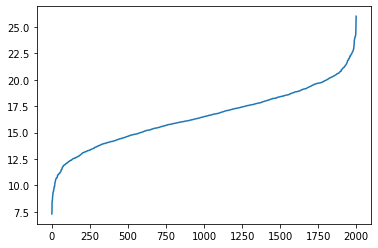

In [26]:
plt.plot(sorted(total_curvatures))
plt.show()

In [27]:
mean = np.mean(total_curvatures)
pdf_values = np.array([(y-mean)**4 for y in total_curvatures])
mass = np.sum(pdf_values)
pdf_values /= mass

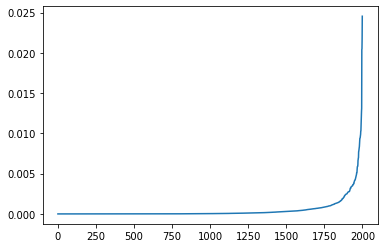

In [28]:
plt.plot(sorted(pdf_values))

In [95]:
t = 0.1
p = 2
task = 'mode'

if task == 'mode':        
#     kernel = np.exp(-D**2/(4*t))/(4*np.pi*t)**(1/2)

    kernel = np.exp(-D**2/t)
    
    D_diff = pairwise_squared_distances(kernel)

    deviation_values = np.sum(D_diff**p*pdf_values,axis = 1)**(1/p)
    
elif task == 'mean':
    
    deviation_values = np.sum(D**p*pdf_values,axis = 1)**(1/p)

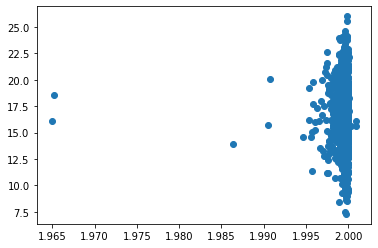

In [96]:
plt.scatter(deviation_values,total_curvatures)
plt.show()

In [97]:
num_neighbors = 20

G = knn_graph_from_distance_matrix(D,num_neighbors)

In [38]:
%%time

f = {i:deviation_values[i] for i in range(len(G))}

T = simplify_merge_tree(get_merge_tree(G,f))

CPU times: user 39.5 s, sys: 131 ms, total: 39.6 s
Wall time: 39.8 s


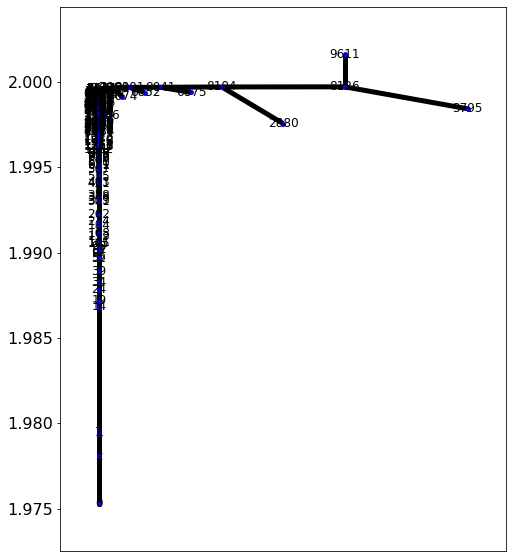

In [39]:
height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(T, pos=pos, with_labels=True,node_size = 15, node_color='blue',width = 5)

ax = plt.gca()

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

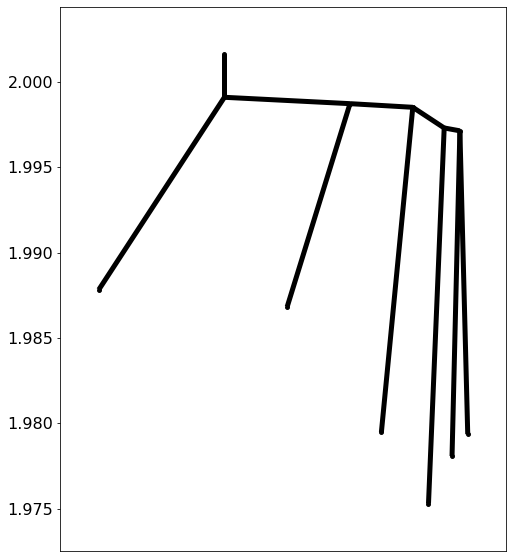

In [48]:
num_leaves = 1000
threshold = 0.01
it = 0

while num_leaves > 10 and it < 20:
    
    TNew = fully_simplify_merge_tree(T,threshold)
    leaves = [node for node in TNew.nodes() if TNew.degree(node)==1]
    num_leaves = len(leaves)
    threshold += .01
    it += 1
    
if it == 20:
    print('Max Iterations Reached')

height = {node:TNew.nodes[node]['height'] for node in TNew.nodes()}
pos = mergeTree_pos(TNew,height)

fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(TNew, pos=pos, with_labels=False,node_size = 15, node_color='black',width = 5)

ax = plt.gca()

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

In [49]:
leaves = [node for node in TNew.nodes() if TNew.degree(node)==1]
print('Num Leaves:',len(leaves))

Num Leaves: 7


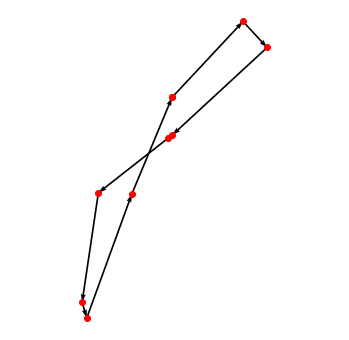

Index: 1290
Total Curvature: 7.450639934688253


In [50]:
leaf = 3

draw_polygon(polygons[list(T.nodes[leaves[leaf]]['subset'])[0]])
print('Index:',list(T.nodes[leaves[leaf]]['subset'])[0])
print('Total Curvature:', total_curvature(polygons[list(T.nodes[leaves[leaf]]['subset'])[0]]))

In [51]:
for i in range(len(leaves)-1):
    leaf = i
    print('Total Curvature:', total_curvature(polygons[list(T.nodes[leaves[leaf]]['subset'])[0]]))

Total Curvature: 26.025803935094956
Total Curvature: 7.299222361078411
Total Curvature: 25.61042777030617
Total Curvature: 7.450639934688253
Total Curvature: 24.649109215943337
Total Curvature: 8.55669767773354


### Figures for Paper

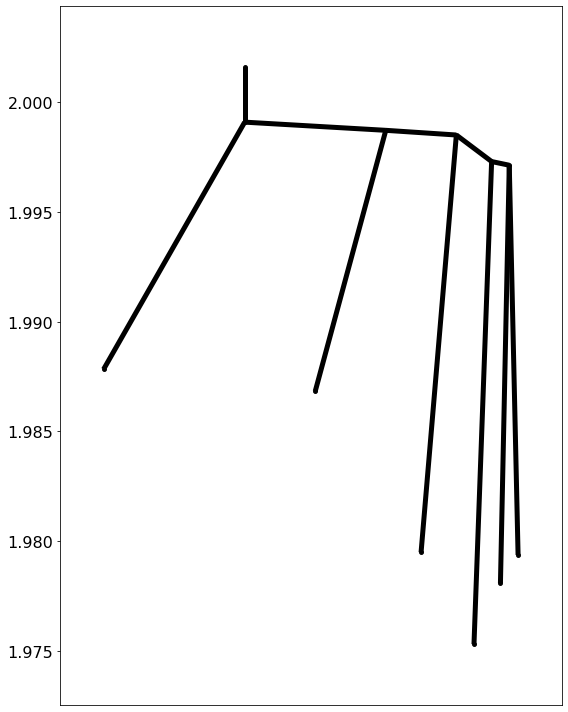

In [52]:
fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(TNew, pos=pos, with_labels=False,node_size = 15, node_color='black',width = 5)

ax = plt.gca()

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

plt.tight_layout()

plt.savefig('polygons-modeMergeTree2.png',format='png',dpi=300)

plt.show()

In [53]:
leaf_polygons = [polygons[list(T.nodes[leaves[i]]['subset'])[0]] for i in [1,2,3,0]]
TCs = [np.round(total_curvature(polygons[list(T.nodes[leaves[i]]['subset'])[0]]),2) for i in [1,2,3,0]]

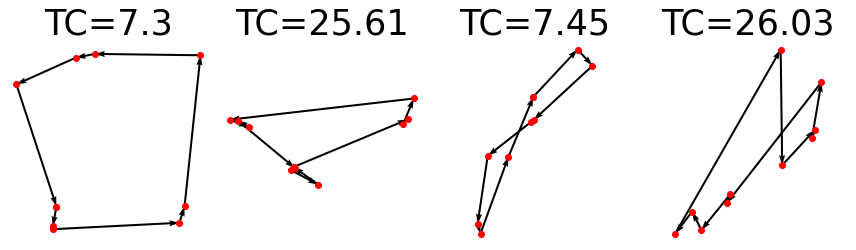

In [54]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes = axes.flatten()

leaf_polygons

for i in range(4):
    P = leaf_polygons[i]
    start_points = P
    end_points = np.roll(P, shift=-1, axis=0)
    vectors = end_points - start_points

    ax = axes[i]
    ax.quiver(start_points[:,0], start_points[:,1], 
              vectors[:,0], vectors[:,1], 
              angles='xy', scale_units='xy', scale=1, 
              width=0.01, color='black')
    
    ax.plot(P[:,0], P[:,1], 'o', color='red')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_box_aspect(1)
    ax.set_frame_on(False)
    ax.set_title(f'TC={TCs[i]}',fontsize = 35)

plt.tight_layout()

plt.savefig('polygons-curvature_examples.png',format = 'png',dpi = 300)
plt.show()

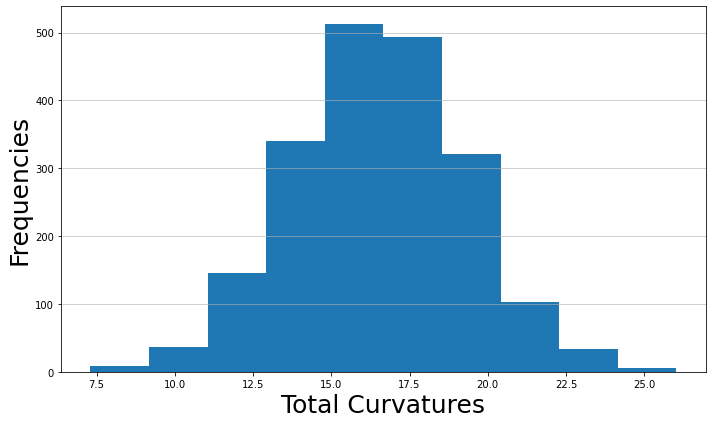

In [55]:
plt.figure(figsize=(10, 6))
plt.hist(total_curvatures, bins=10)
# plt.title('Histogram of Total Curvatures', fontsize=25)
plt.xlabel('Total Curvatures', fontsize=25)
plt.ylabel('Frequencies', fontsize=25)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.savefig('polygons-TC_Histogram.png',format = 'png', dpi = 300)
plt.show()

### Experiment - Distance from fixed points distribution

In [56]:
num_sides = 10
num_stiefel_samples = len(stiefel_samples)

In [57]:
s = 0.5

anchor0 = 0
anchor1 = np.argmax(np.array([grassmann_geodesic_distance(stiefel_samples[anchor0],stiefel_samples[j]) for j in range(num_stiefel_samples)]))

dists_from_0 = [grassmann_geodesic_distance(stiefel_samples[anchor0],stiefel_samples[j]) for j in range(num_stiefel_samples)]
dists_from_1 = [grassmann_geodesic_distance(stiefel_samples[anchor1],stiefel_samples[j]) for j in range(num_stiefel_samples)]

pdf_values = np.array([np.exp(-dists_from_0[j]**2/s) + np.exp(-dists_from_1[j]**2/s) for j in range(num_stiefel_samples)])
mass = np.sum(pdf_values)

pdf_values = pdf_values/mass

print('Anchor 1 ID:',anchor1)

Anchor 1 ID: 1629


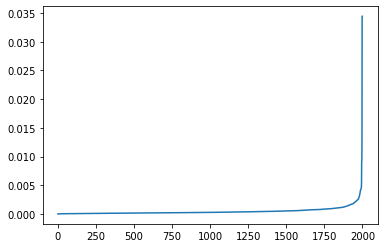

In [58]:
plt.plot(sorted(pdf_values))
plt.show()

In [98]:
t = 0.1
p = 2
task = 'mode'

if task == 'mode':        
    kernel = np.exp(-D**2/t)

    D_diff = pairwise_squared_distances(kernel)

    deviation_values = np.sum(D_diff**p*pdf_values,axis = 1)**(1/p)
    
elif task == 'mean':
    
    deviation_values = np.sum(D**p*pdf_values,axis = 1)**(1/p)

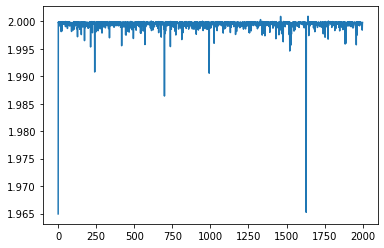

In [99]:
plt.plot(deviation_values)
plt.show()

In [100]:
num_neighbors = 20

G = knn_graph_from_distance_matrix(D,num_neighbors)

In [101]:
%%time

f = {i:deviation_values[i] for i in range(len(G))}

T = simplify_merge_tree(get_merge_tree(G,f))

CPU times: user 40.5 s, sys: 107 ms, total: 40.6 s
Wall time: 40.7 s


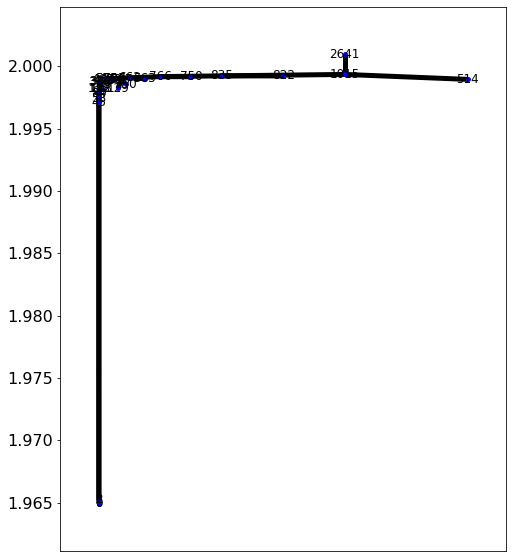

In [102]:
height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(T, pos=pos, with_labels=True,node_size = 15, node_color='blue',width = 5)

ax = plt.gca()

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

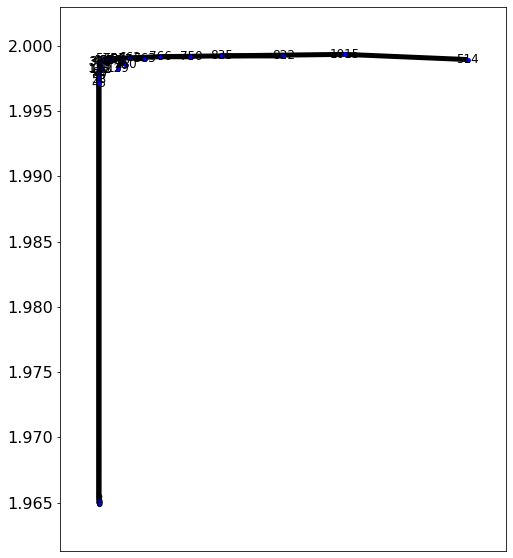

In [105]:
TNew = get_subtree(T,2)

height = {node:TNew.nodes[node]['height'] for node in TNew.nodes()}
pos = mergeTree_pos(TNew,height)

fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(TNew, pos=pos, with_labels=True,node_size = 15, node_color='blue',width = 5)

ax = plt.gca()

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

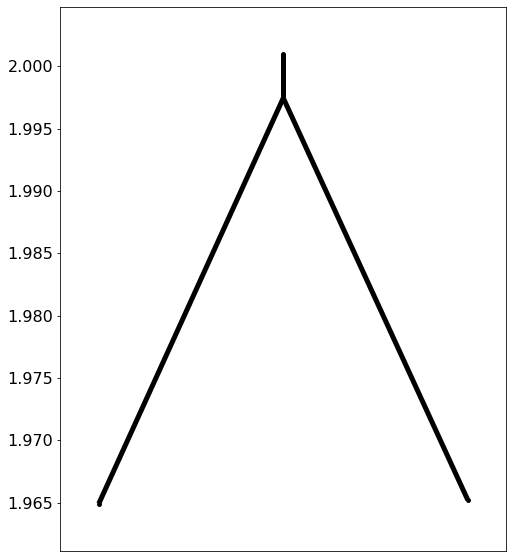

In [106]:
num_leaves = 1000
threshold = 0.001
it = 0

while num_leaves > 10 and it < 20:
    
    TNew = fully_simplify_merge_tree(T,threshold)
    leaves = [node for node in TNew.nodes() if TNew.degree(node)==1]
    num_leaves = len(leaves)
    threshold += .01
    it += 1
    
if it == 20:
    print('Max Iterations Reached')

height = {node:TNew.nodes[node]['height'] for node in TNew.nodes()}
pos = mergeTree_pos(TNew,height)

fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(TNew, pos=pos, with_labels=False,node_size = 15, node_color='black',width = 5)

ax = plt.gca()

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

In [107]:
leaves = [node for node in TNew.nodes() if TNew.degree(node)==1]
print('Num Leaves:',len(leaves))

Num Leaves: 3


In [108]:
leaves

[0, 2, 2641]

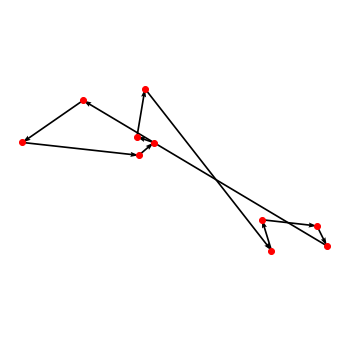

Index: 1629


In [112]:
leaf = 1

draw_polygon(polygons[list(TNew.nodes[leaves[leaf]]['subset'])[0]])
print('Index:',list(TNew.nodes[leaves[leaf]]['subset'])[0])

### Figures for the paper

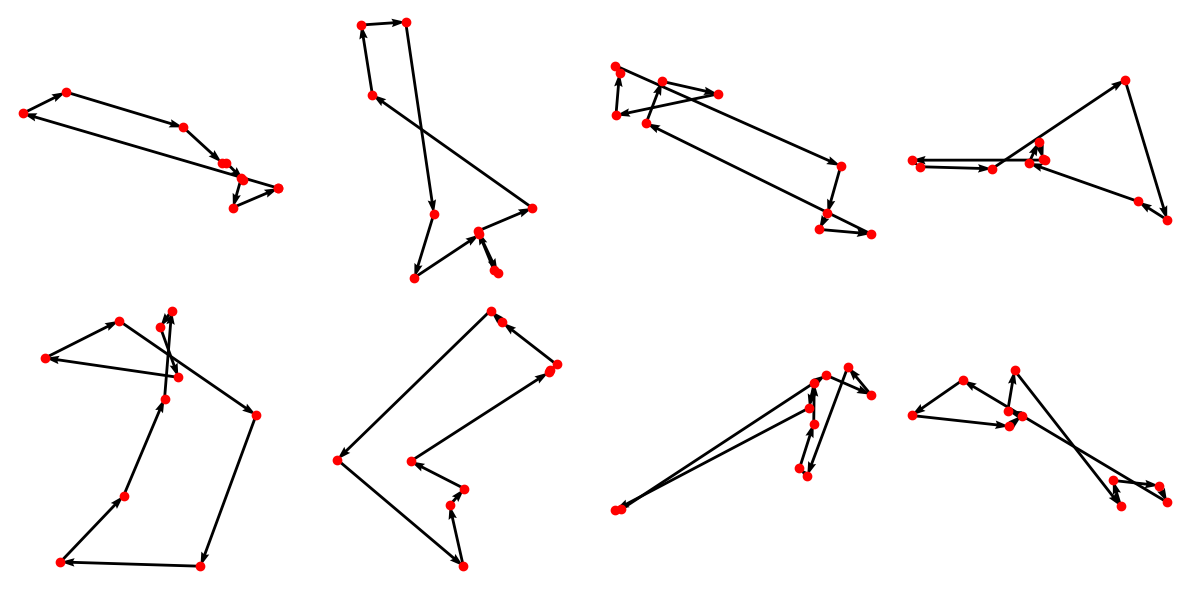

In [87]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

polygons2 = polygons[:7] + [polygons[anchor1]]

for i in range(8):
    P = polygons2[i]
    start_points = P
    end_points = np.roll(P, shift=-1, axis=0)
    vectors = end_points - start_points

    ax = axes[i]
    ax.quiver(start_points[:,0], start_points[:,1], 
              vectors[:,0], vectors[:,1], 
              angles='xy', scale_units='xy', scale=1, 
              width=0.01, color='black')
    
    ax.plot(P[:,0], P[:,1], 'o', color='red')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_box_aspect(1)
    ax.set_frame_on(False)

plt.tight_layout()

plt.savefig('polygons-samples.png',format = 'png',dpi = 300)
plt.show()


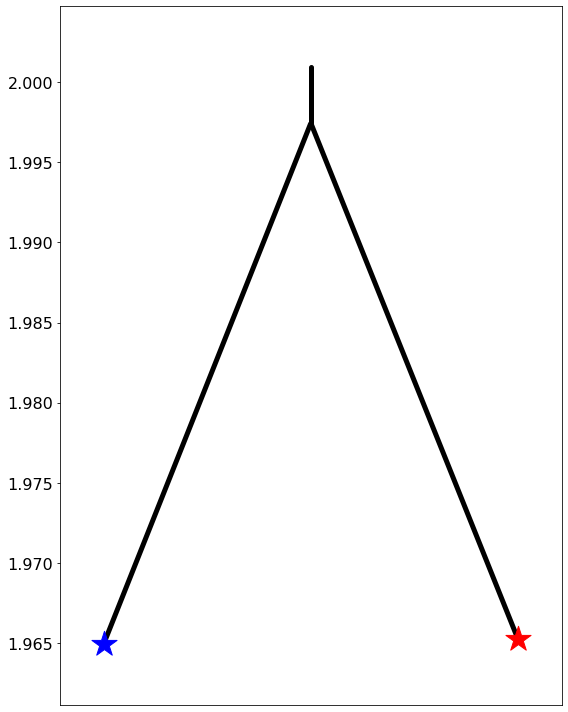

In [113]:
fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(TNew, pos=pos, with_labels=False,node_size = 15, node_color='black',width = 5)

ax = plt.gca()

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

node = leaves[0]
x = np.array([pos[node][0]])
y = np.array([pos[node][1]])
plt.scatter(x, y, color='blue', s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

node = leaves[1]
x = np.array([pos[node][0]])
y = np.array([pos[node][1]])
plt.scatter(x, y, color='red', s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

plt.tight_layout()

plt.savefig('polygons-modeMergeTree1.png',format='png',dpi=300)

plt.show()

### Experiment

We create a generative shape model.

In [ ]:
num_sides = 3
num_samples_class_1 = 100
num_samples_class_2 = 100

### Class 1

mean1 = [2,0]
cov1 = [[.1,0],[0,.1]]

### Class 2
 
mean2 = [5,0]
cov2 = [[1,0],[0,1]]

#####

class1_samples = [random_planar_polygon(num_sides, mean = mean1, cov = cov1) for j in range(num_samples_class_1)]
class2_samples = [random_planar_polygon(num_sides, mean = mean2, cov = cov2) for j in range(num_samples_class_2)]

polygons = np.array(class1_samples + class2_samples)

In [ ]:
for j in range(10):
    draw_polygon(polygons[j])

In [ ]:
for j in range(10):
    draw_polygon(polygons[100+j])

Now we sample the Stiefel manifold randomly and append the lifted polygon samples.

In [ ]:
num_stiefel_samples = 500

stiefel_samples = sample_stiefel(num_sides,num_stiefel_samples)
lifted_polygons = [polygon_to_grassmannian(P) for P in polygons]

stiefel_samples = stiefel_samples + lifted_polygons

We now prepare the pairwise diffusion distances for all points in the Stiefel manifold. We use geodesic distance in the Grassmannian.

In [ ]:
%%time
num_samp = len(stiefel_samples)

D = np.zeros([num_samp,num_samp])

for i in range(num_samp):
    X = stiefel_samples[i]
    for j in range(i+1,num_samp):
        Y = stiefel_samples[j]
        D[i,j] = grassmann_geodesic_distance(X,Y)
        
D = D + D.T

In [ ]:
plt.imshow(D)
plt.show()

We run the distance matrix through an exponential kernel. This depends on a scale parameter $t$.

In [ ]:
t = 0.1

kernel = np.exp(-D**2/(4*t))/(4*np.pi*t)**(1/2)

plt.imshow(kernel)
plt.show()

The kernel is used to define diffusion distances.

In [ ]:
def pairwise_squared_distances(kernel):
    # Compute the squared norms of each row (shape: [n])
    row_norms = np.sum(kernel**2, axis=1)
    
    # Compute the Gram matrix (dot product between all rows)
    gram = kernel @ kernel.T

    # Apply the formula: ||a - b||^2 = ||a||^2 + ||b||^2 - 2*a.b
    return row_norms[:, None] + row_norms[None, :] - 2 * gram

In [ ]:
%%time
dx = 1/num_samp

# D_diff = dx * np.sum((kernel[:,None,:] - kernel[None,:,:])**2, axis=2)

# D_diff = D_diff**(1/2)

D_diff = pairwise_squared_distances(kernel)

plt.imshow(D_diff)
plt.show()

In [ ]:
pdf_values = np.array([0]*num_stiefel_samples + [1]*num_samples_class_1 + [1]*num_samples_class_2)/num_samp

In [ ]:
p = 2
deviation_values = np.sum(D_diff**p*pdf_values,axis = 1)**(1/p)

In [ ]:
def knn_graph_from_distance_matrix(D, k, symmetric=True):
    """
    Create a k-nearest neighbors graph from a distance matrix.

    Parameters:
        D (np.ndarray): n-by-n distance matrix.
        k (int): Number of nearest neighbors per node.
        symmetric (bool): Whether to symmetrize the graph (mutual kNN).

    Returns:
        G (networkx.Graph): A k-NN graph with edge weights.
    """
    n = D.shape[0]
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(n))

    # Get k nearest neighbors for each node
    for i in range(n):
        # Exclude self, get indices of k smallest distances
        knn_indices = np.argpartition(D[i], k + 1)[:k + 1]
        knn_indices = knn_indices[knn_indices != i][:k]

        for j in knn_indices:
            weight = D[i, j]
            if symmetric:
                # Add edge only once, with min weight if both directions exist
                if G.has_edge(i, j):
                    G[i][j]['weight'] = min(G[i][j]['weight'], weight)
                else:
                    G.add_edge(i, j, weight=weight)
            else:
                G.add_edge(i, j, weight=weight)

    return G

In [ ]:
%%time

G = knn_graph_from_distance_matrix(D,3)

In [ ]:
%%time

f = {i:deviation_values[i] for i in range(len(G))}

T = simplify_merge_tree(get_merge_tree(G,f))

In [ ]:
height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 15, node_color='blue',width = 5)


In [ ]:
leaves = [node for node in T.nodes() if T.degree(node)==1]

In [ ]:
leaves

In [ ]:
len(leaves)

In [ ]:
leaf = 0

draw_polygon(polygons[list(T.nodes[leaves[leaf]]['subset'])[0]])
print('Total Curvature:', total_curvature(polygons[list(T.nodes[leaves[leaf]]['subset'])[0]]))

In [ ]:
total_curvature(polygons[list(T.nodes[leaves[0]]['subset'])[0]])

In [ ]:
T.nodes[leaves[1]]['subset']

In [ ]:
T.nodes[leaves[2]]['subset']

In [ ]:
T.nodes[leaves[4]]['subset']

In [ ]:
T.nodes[leaves[5]]['subset']

#### NEW

In [ ]:
num_sides = 10
num_stiefel_samples = 200

stiefel_samples = sample_stiefel(num_sides,num_stiefel_samples)
polygons = [grassmannian_to_polygon(F) for F in stiefel_samples]

In [ ]:
s = 0.5

anchor0 = 0
anchor1 = np.argmax(np.array([grassmann_geodesic_distance(stiefel_samples[anchor0],stiefel_samples[j]) for j in range(num_stiefel_samples)]))

dists_from_0 = [grassmann_geodesic_distance(stiefel_samples[anchor0],stiefel_samples[j]) for j in range(num_stiefel_samples)]
dists_from_1 = [grassmann_geodesic_distance(stiefel_samples[anchor1],stiefel_samples[j]) for j in range(num_stiefel_samples)]

pdf_values = np.array([np.exp(-dists_from_0[j]**2/s) + np.exp(-dists_from_1[j]**2/s) for j in range(num_stiefel_samples)])
mass = np.sum(pdf_values)

pdf_values = pdf_values/mass

print(anchor1)

In [ ]:
draw_polygon(polygons[0])

In [ ]:
draw_polygon(polygons[anchor1])

In [ ]:
plt.plot(pdf_values)

In [ ]:
%%time
num_samp = len(stiefel_samples)

D = np.zeros([num_samp,num_samp])

for i in range(num_samp):
    X = stiefel_samples[i]
    for j in range(i+1,num_samp):
        Y = stiefel_samples[j]
        D[i,j] = grassmann_geodesic_distance(X,Y)
        
D = D + D.T

In [ ]:
plt.imshow(D)
plt.show()

We run the distance matrix through an exponential kernel. This depends on a scale parameter $t$.

In [ ]:
t = 0.1

kernel = np.exp(-D**2/(4*t))/(4*np.pi*t)**(1/2)

plt.imshow(kernel)
plt.show()

The kernel is used to define diffusion distances.

In [ ]:
def pairwise_squared_distances(kernel):
    # Compute the squared norms of each row (shape: [n])
    row_norms = np.sum(kernel**2, axis=1)
    
    # Compute the Gram matrix (dot product between all rows)
    gram = kernel @ kernel.T

    # Apply the formula: ||a - b||^2 = ||a||^2 + ||b||^2 - 2*a.b
    return row_norms[:, None] + row_norms[None, :] - 2 * gram

In [ ]:
%%time
dx = 1/num_samp

# D_diff = dx * np.sum((kernel[:,None,:] - kernel[None,:,:])**2, axis=2)

# D_diff = D_diff**(1/2)

D_diff = pairwise_squared_distances(kernel)

plt.imshow(D_diff)
plt.show()

In [ ]:
p = 2
deviation_values = np.sum(D_diff**p*pdf_values,axis = 1)**(1/p)

In [ ]:
pdf_values = np.array([1]*num_stiefel_samples)
mass = np.sum(pdf_values)
pdf_values = pdf_values/mass

In [ ]:
p = 2
deviation_values = np.sum(D**p*pdf_values,axis = 1)**(1/p)

In [ ]:
def knn_graph_from_distance_matrix(D, k, symmetric=True):
    """
    Create a k-nearest neighbors graph from a distance matrix.

    Parameters:
        D (np.ndarray): n-by-n distance matrix.
        k (int): Number of nearest neighbors per node.
        symmetric (bool): Whether to symmetrize the graph (mutual kNN).

    Returns:
        G (networkx.Graph): A k-NN graph with edge weights.
    """
    n = D.shape[0]
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(n))

    # Get k nearest neighbors for each node
    for i in range(n):
        # Exclude self, get indices of k smallest distances
        knn_indices = np.argpartition(D[i], k + 1)[:k + 1]
        knn_indices = knn_indices[knn_indices != i][:k]

        for j in knn_indices:
            weight = D[i, j]
            if symmetric:
                # Add edge only once, with min weight if both directions exist
                if G.has_edge(i, j):
                    G[i][j]['weight'] = min(G[i][j]['weight'], weight)
                else:
                    G.add_edge(i, j, weight=weight)
            else:
                G.add_edge(i, j, weight=weight)

    return G

In [ ]:
%%time

G = knn_graph_from_distance_matrix(D,5)

In [ ]:
%%time

f = {i:deviation_values[i] for i in range(len(G))}

T = simplify_merge_tree(get_merge_tree(G,f))

In [ ]:
height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(T, pos=pos, with_labels=True,node_size = 15, node_color='blue',width = 5)

ax = plt.gca()

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

In [ ]:
def get_next_ancestor(T,node):
   
    neighbors = [nb for nb in T.neighbors(node)]
    current_height = T.nodes[node]['height']
    heights = [T.nodes[n]['height'] for n in T.nodes()]
    
    if current_height == max(heights):
        return None
    else:
        for nb in neighbors:
            if T.nodes[nb]['height'] > current_height:
                neighbor = nb
                break
            
        return neighbor

In [ ]:
def prune_merge_tree(T,threshold):
    
    TNew = T.copy()
    
    leaves = [node for node in T.nodes() if T.degree(node)==1]
    
    for leaf in leaves:
        
        leaf_anc = get_next_ancestor(T,leaf)
        
        if leaf_anc is not None:
            
            if T.nodes[leaf_anc]['height'] - T.nodes[leaf]['height'] < threshold:
                
                TNew.remove_node(leaf)
                
    return TNew

In [ ]:
threshold = 0.01

TNew = simplify_merge_tree(prune_merge_tree(T,threshold))
# TNew = simplify_merge_tree(prune_merge_tree(TNew,0.1))

height = {node:TNew.nodes[node]['height'] for node in TNew.nodes()}
pos = mergeTree_pos(TNew,height)

fig, ax = plt.subplots(figsize=(8, 10))

nx.draw_networkx(TNew, pos=pos, with_labels=True,node_size = 15, node_color='black',width = 5)

In [ ]:
leaves = [node for node in TNew.nodes() if TNew.degree(node)==1]

In [ ]:
leaves

In [ ]:
len(leaves)

In [ ]:
leaf = 1

draw_polygon(polygons[list(T.nodes[leaves[leaf]]['subset'])[0]])
print('Index:',list(T.nodes[leaves[leaf]]['subset'])[0])
print('Total Curvature:', total_curvature(polygons[list(T.nodes[leaves[leaf]]['subset'])[0]]))

In [ ]:
total_curvature(polygons[list(T.nodes[leaves[0]]['subset'])[0]])

In [ ]:
T.nodes[leaves[1]]['subset']

In [ ]:
T.nodes[leaves[2]]['subset']

In [ ]:
T.nodes[leaves[4]]['subset']

In [ ]:
T.nodes[leaves[5]]['subset']